# Breast Cancer Cell Lines: Preprocess Data
In this notebook we preprocess our data for downstream locus-based analysis. Data includes:
* smRNA seq data of the breast cancer (and normal) cell lines used in our Nature Med paper (Fish, 2018)
* smRNA seq data from TCGA: specifically all the BRCA samples and all the normal samples from all tissue types in TCGA. 
* smRNA seq data from exRNA Atlas along with other publically available datasets from non-cancerous exosomal smRNA samples

In [1]:
import pandas as pd
import numpy as np
import os
import pysam
import re
import json as js
from scipy.signal import find_peaks, peak_widths
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Preprocess Cell Lines Data
Dataset involves 21 samples:
* 3 samples from HMEC cell lines
* 18 samples from 

In [2]:
cell_lines = [f for f in os.scandir("data/IC/") if f.name.endswith(".srt.dd.bam")]
len(cell_lines)

21

### Dust

Since we are converting the bam files to bed format, we first remove the low complexity sequences in the bam files first.

In [3]:
"""Simple dust score adapted from Dust Algorithm Score: A fast and symmetric DUST implementation to mask
low-complexity DNA sequences (2006, Morgulis et al.)"""
def simpleDustScore(seq):
    assert len(seq) > 2
    if len(seq) == 3:
        return 0
    else:
        triplets = {}
        num_trip = len(seq) - 2
        for i in range(num_trip):
            subseq = seq[i:i+3]
            if subseq in triplets:
                triplets[subseq] += 1
            else:
                triplets[subseq] = 1
        sum_triplet = 0
        for triplet, count in triplets.items():
            sum_triplet += count * (count - 1) / 2
        return sum_triplet/(num_trip - 1)

In [4]:
for f in cell_lines: 
    name = f.name.split(".")[0]
    out = f"data/IC/{name}.srt.dd.dust.bam"
    infile = pysam.AlignmentFile(f, "rb")
    outfile = pysam.AlignmentFile(out, "wb", template=infile)
    for read in infile.fetch():
        if simpleDustScore(read.get_forward_sequence()) < 3 and len(read.get_forward_sequence()) >= 15:
            outfile.write(read)
    outfile.close()
    infile.close()

### BedtoBam
Next we convert all the cell lines bam alignment files to bedfiles. 

In [5]:
%%bash
for f in data/IC/*.srt.dd.dust.bam;
do 
base=$(basename $f)
out=${base/.bam/.bed}
echo "$bedtools bamtobed -i $f > data/IC/$out"
bedtools bamtobed -i $f > data/IC/$out
done &> log/cell_lines_bamtobed.out

### Filter Cell Lines Bed

In [6]:
for f in os.scandir("data/IC"):
    if f.name.endswith(".srt.dd.dust.bed"):
        name = f.name.split(".")[0]
        outfile = f"data/IC/{name}.filter.bed"
        with open(outfile, "wt") as out, open(f, "rt") as file:
            for line in file:
                if re.match("chr[\d+,X,Y]", line) and "None" not in line:
                    out.write(line) 

### Merge Cell Lines Loci
Here we merge all the loci seen in the cell lines data to create a locus feature map. No threshold set for degree of overlap.

In [7]:
%%bash
cat data/IC/*.filter.bed | sort -k1,1 -k2,2n | mergeBed -s -c 6 -o distinct -i stdin | \
awk '{print $1 "\t" $2 "\t" $3 "\t" $1":"$2"-"$3":"$4  "\t." "\t" $4  > "data/cell_lines_smRNAs_merged_loci.bed"}' 

## Split Loci By Peaks

Since some loci are larger than 200 bp, we will need to split these loci up by coverage. <br>
First we merge all the cell lines sample bamfiles to run `bedtools genomecov`. Based on coverage peaks we will separate the larger loci into smaller ones.

In [8]:
%%bash
samtools merge data/IC/all_samples.bam data/IC/*srt.dd.dust.bam

In [9]:
%%bash
bedtools genomecov -ibam data/IC/all_samples.bam -bg -strand - > data/IC/all_samples_neg_bg.txt

In [10]:
%%bash
bedtools genomecov -ibam data/IC/all_samples.bam -bg -strand + > data/IC/all_samples_pos_bg.txt

In [11]:
all_loci = pd.read_csv("data/cell_lines_smRNAs_merged_loci.bed", header=None, sep="\t")
all_loci["length"] = all_loci[2] - all_loci[1] #Calculate length of each locus
loci_to_split = all_loci[all_loci["length"] > 200]
loci_to_split.head()

,0,1,2,3,4,5,length
224,chr1,629083,630075,chr1:629083-630075:+,.,+,992
225,chr1,629218,629905,chr1:629218-629905:-,.,-,687
228,chr1,630084,630520,chr1:630084-630520:+,.,+,436
231,chr1,630317,630520,chr1:630317-630520:-,.,-,203
237,chr1,630645,631429,chr1:630645-631429:-,.,-,784


In [12]:
pos_density = pd.read_csv("data/IC/all_samples_pos_bg.txt", header=None, sep="\t")
neg_density = pd.read_csv("data/IC/all_samples_neg_bg.txt", header=None, sep="\t")
pos_density.head()

,0,1,2,3
0,chr1,11046,11061,1
1,chr1,11237,11258,1
2,chr1,11768,11785,1
3,chr1,12036,12072,1
4,chr1,17017,17035,1


In [13]:
new_loci_list = []
for i in range(loci_to_split.shape[0]):
    rna = loci_to_split.iloc[i]
    density = neg_density if rna[5] == "-" else pos_density
    density = density[density[0] == rna[0]] #Match reference chr
    density = density[(density[1] >= rna[1]) & (density[2] <= rna[2])] #Match rna locus. Since the loci area already merged, the coverage start and end positions should match seamlessly.
    coord, coverage = [], []
    assert density.iloc[0][1] == rna[1]
    assert density.iloc[-1][2] == rna[2] 
    posit = density.iloc[0][1] #Start of locus
    for i in range(density.shape[0]):
        row = density.iloc[i]
        start, end, count = row[1], row[2], row[3]
        
        #Mergebed and genomecov results have about 6 loci that are off by 1~3 bps. Here we fix continuity  
        while posit < start:
            coord.append(posit)
            coverage.append(0) #Bridge gap in genomecov with 0s
            posit += 1
            
        #Generating coverage by each nucletotide position.
        while start < end:
            coord.append(start)
            coverage.append(count)
            start += 1
            posit += 1
            
    peaks, _ = find_peaks(np.array(coverage), height=5, rel_height=0.5, width=[15, 200], distance=20)
    results = peak_widths(np.array(coverage), peaks, rel_height=0.5)
    #peak_widths returns 4 arrays in order: peak widths, peak heights, peak start, peak end.
    for new_start_index,new_end_index in zip(results[2], results[3]):
        new_start_index, new_end_index = int(new_start_index), int(new_end_index) #These are the new indices
        new_start = coord[new_start_index]
        new_end = coord[new_end_index]
        
        if new_end - new_start + 7 < 200: #Add an additional 6 nt buffer if loci length is not too large.
            new_start -= 3
            new_end += 4 #1 nt more for end because bed format is end exclusive.
        new_locus = f"{rna[0]}:{new_start}-{new_end}:{rna[5]}"
        new_loci_list.append(new_locus)
        
len(new_loci_list), loci_to_split.shape[0]

(4400, 1011)

From the 1011 loci greater than 200 bp, we split them into 4400 loci.

In [14]:
loci_list = all_loci[all_loci["length"] <= 200][3].tolist()
loci_list.extend(new_loci_list)
len(loci_list)

1734531

In [15]:
with open("data/cell_lines_smRNAs_split_loci.bed", "wt") as out:   
    for locus in loci_list:
        splits = locus.split(":")
        start = splits[1].split("-")[0]
        end = splits[1].split("-")[1]
        bed = f"{splits[0]}\t{start}\t{end}\t{locus}\t.\t{splits[-1]}"
        out.write(bed + "\n")

In [16]:
%%bash
cat data/cell_lines_smRNAs_split_loci.bed | sort -k1,1 -k2,2n | mergeBed -s -c 6 -o distinct -i stdin | \
awk '{print $1 "\t" $2 "\t" $3 "\t" $1":"$2"-"$3":"$4  "\t." "\t" $4  > "data/cell_lines_smRNAs_loci_map.bed"}' 

In [17]:
loci_map = pd.read_csv("data/cell_lines_smRNAs_loci_map.bed", header=None, sep="\t")[3]
len(loci_map)

1734299

Final number of loci in our feature map is 1734299.

## exRNA Filter Feature Map
Here we filter out all the loci that are also seen in non-cancerous samples from the exRNA Atlas and other publically available non-cancerous exosomal smRNAseq datasets. 

Command: <br>
`ls /rumi/shams/jwang/exRNA_atlas/data/bedfiles/*.srt.filter.bed | parallel -j 30 bash scripts/intersect_exRNA_atlas_loci.sh {} &> log/intersect_exRNA_atlas_loci.out` <br>


The main command in the script is: <br>
`intersectBed -s -u -a data/cell_lines_smRNAs_loci_map.bed -b $1 > data/exRNA/$out` <br>
The `-u` option reports a locus in `-a` **once** when there is at least one overlap with `-b`

### Plot exRNA clean up threshold

In [18]:
exRNA_intersect_files = [f for f in os.scandir("data/exRNA") if os.stat(f).st_size != 0 and f.name.endswith(".bed")] #Exclude empty no hit samples.
len(exRNA_intersect_files)

1383

In [19]:
exRNA_loci_hits = {}
for file in exRNA_intersect_files:
    df = pd.read_csv(file, sep="\t", header=None)
    for locus in df[3]:
        if locus in exRNA_loci_hits:
            exRNA_loci_hits[locus] += 1
        else:
            exRNA_loci_hits[locus] = 1
len(exRNA_loci_hits) #Represents number of loci in our loci feature map that had at least one overlap with a sample in the exRNA atlas

1143299

In [20]:
exRNA_loci_hits_df = pd.DataFrame.from_dict(exRNA_loci_hits, orient="index", columns=["counts"])
exRNA_loci_hits_df = exRNA_loci_hits_df.reset_index(drop=False).rename(columns={"index":"loci"})
exRNA_loci_hits_df.head()

,loci,counts
0,chr1:629497-629544:+,1098
1,chr1:629535-629573:-,1092
2,chr1:629567-629614:+,1187
3,chr1:630746-630788:+,1027
4,chr1:630755-630794:-,799


In [21]:
total_loci_num = 1734299
exRNA_filter_results = {"threshold":[], "count":[]}
for th in range(1, 50):
    exRNA_filter_results["threshold"].append(th)
    exRNA_filter_results["count"].append(total_loci_num - np.sum(exRNA_loci_hits_df["counts"] >= th)) #Number of total loci minus number of loci eliminated (loci that intersected with or more than th samples) given a threshold TH
exRNA_filter_results = pd.DataFrame(exRNA_filter_results)

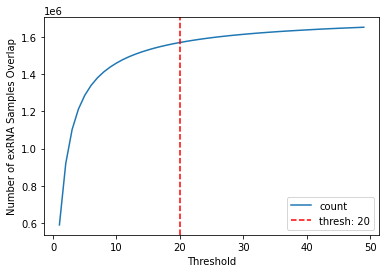

In [22]:
plt.plot('threshold', 'count', data=exRNA_filter_results)
plt.xlabel("Threshold")
plt.ylabel("Number of exRNA Samples Overlap")
ax = plt.gca()
cutoff=20
ax.axvline(cutoff, color = "r", ls="--", label=f"thresh: {cutoff}")
plt.legend()
plt.savefig("figures/exRNA_atlas_samples_filter_thresh.pdf")

Here we choose a cutoff of 20. If a locus is found (overlapped) in at least 20 exRNA samples, we will remove from consideration.

In [23]:
to_remove = set(exRNA_loci_hits_df[exRNA_loci_hits_df["counts"] >= 20]["loci"])
len(to_remove)

165016

In [24]:
exRNA_filtered_loci = []
for locus in loci_map:
    if locus not in to_remove:
        exRNA_filtered_loci.append(locus)
len(exRNA_filtered_loci)

1569283

At this exRNA cleanup step, we removed about 9.5% of our feature loci. Removing 165016 loci from 1734299.

In [25]:
with open("data/cell_lines_smRNAs_loci_map_exRNA_filtered.bed", "w") as out: 
    for locus in exRNA_filtered_loci:
        splits = locus.split(":")
        start = splits[1].split("-")[0]
        end = splits[1].split("-")[1]
        bed = f"{splits[0]}\t{start}\t{end}\t{locus}\t.\t{splits[-1]}"
        out.write(bed + "\n")

## Create Counts
Last preprocess step for the cell lines is to create counts for each cell line sample for each smRNA loci feature.

In [26]:
%%bash 
for f in data/IC/*.filter.bed;
do
out=${f/.filter.bed/.exRNA.intersect.bed}
echo "intersectBed -s -wo -a $f -b data/cell_lines_smRNAs_loci_map_exRNA_filtered.bed > $out"
intersectBed -s -wo -a $f -b data/cell_lines_smRNAs_loci_map_exRNA_filtered.bed > $out
done &> log/cell_lines_exRNA_intersect.out

In [27]:
%%bash 
for f in data/IC/*.filter.bed;
do
out=${f/.filter.bed/.intersect.bed}
echo "intersectBed -s -wo -a $f -b data/cell_lines_smRNAs_loci_map.bed > $out"
intersectBed -s -wo -a $f -b data/cell_lines_smRNAs_loci_map.bed > $out
done &> log/cell_lines_intersect.out

In [28]:
sample_loci = {}
cpm_map = {}
exRNA_filtered_cell_lines = [f for f in os.scandir("data/IC/") if f.name.endswith(".exRNA.intersect.bed")]
for f in exRNA_filtered_cell_lines:  
    
    sample = f.name.split(".")[0]
    bed_file = pd.read_csv(f"data/IC/{sample}.filter.bed", header=None, sep="\t")
    assert len(bed_file[3].unique()) == bed_file.shape[0] #Ensures number of unique reads (query_id) matches total number of reads in bed file, so that we are not over counting
    #cpm calculations: total reads within pre-exRNA filtered bedfile. Note reads that had "chrUn" or low-complexity seqeunces where filered out and not included in cpm normalization.           
    cpm = 1000000/bed_file.shape[0]
    cpm_map[sample] = cpm
    
    #Counts of exRNA filtered loci
    ex_fil_bed = pd.read_csv(f, header=None, sep="\t")
    loci_features = ex_fil_bed[9] #Locus annotation as a feature.
    loci_bp_overlaps = ex_fil_bed[12] #Number of bp overlaps between read and locus annotation.
    read_ids = ex_fil_bed[3] #Query ID from original bamfile for each read.
    
    #First create read_id map
    read_id_locus_map = {}
    for i in range(len(read_ids)):
        _id = read_ids.iloc[i]
        num_bp_match = loci_bp_overlaps.iloc[i]
        locus = loci_features.iloc[i]
        
        if _id in read_id_locus_map: #Indicates multiple hits/overlaps for one read.
            if num_bp_match > read_id_locus_map[_id]["bp"]: #Update locus count if more number of bp matched. This is our simple binning procedure.
                read_id_locus_map[_id] = {"locus":locus, "bp":num_bp_match}
        else:
            read_id_locus_map[_id] = {"locus":locus, "bp":num_bp_match}
            
    assert len(read_id_locus_map) == len(ex_fil_bed[3].unique()) #Ensures we do not overcount reads   
    
    #Counts of loci
    sample_loci[sample] = {}
    for _id in read_id_locus_map: 
        locus = read_id_locus_map[_id]["locus"] 
        if locus in sample_loci[sample]:
            sample_loci[sample][locus] += 1
        else:
            sample_loci[sample][locus] = 1

In [29]:
with open('data/counts/cell_lines_loci_counts.json', 'w') as f:
    js.dump(sample_loci, f)
    f.close()
    
with open ("data/counts/cell_lines_cpm_map.json", "w") as f:
    js.dump(cpm_map, f)
    f.close()

## Preprocess TCGA Data
Since TCGA datasets are quite bit larger, we run the following pre-processing steps as scripts instead of in this notebook. All scripts can be found in the `scripts` directory. <br>
TCGA dataset we use in this project involves: 679 normal samples from varying tissues and 1103 BRCA cancer samples.
<br>

### Dust 
Eliminate low-complexity sequences

Command used in smRNA env: <br>
`python3 scripts/dust_filter.py &> log/dust_filter_TCGA.out`

### Bamtobed
Convert all the filtered bam files to bed files.

Command used in smRNA env: <br>
`ls /rumi/shams/jwang/BRCA_oncRNA/data/TCGA/*.dust.bam | parallel -j 30 bash scripts/bamtobed.sh {} &> log/bamtobed_TCGA.out`

### Filter TCGA Data
TCGA bed data contains certain formats that are not compatible with bedtools and are not of interest (ex: chrUn). Here we filter our TCGA data before further processing.

Command used in smRNA env: <br>
`python3 scripts/filter_TCGA.py &> log/filter_TCGA.out`

# Conclusion
Finished preprocessing and creating counts for loci found in our cell lines and preprocessing TCGA data. <br>
Next step is identify cancer-enriched RNAs.